In [1]:
# Author: Brent Artuch
# Date: 2024-10-26

import sympy as sp
from sympy.physics.quantum import *
import numpy as np
from IPython.display import *

# Qiskit and Q# libraries
import qsharp
from qiskit.quantum_info import Operator, Statevector
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT

sp.init_printing()

## Fourier Series
A fourier series is defined as an expansion of a function in a series of sines and cosines dentoted:
\begin{align*}
f(x)=\frac{1}{2}a_0+\sum_{n=1}^{\infty}a_n\cos (nx)+\sum_{n=1}^{\infty}b_n\sin (nx)
\end{align*}

The coefficients $a_0$, $a_n$, and $b_n$ are related to $f(x)$ by definite integrals:
\begin{align*}
\frac{1}{\pi}\int_{0}^{2\pi}f(s)\cos (ns) \ ds=
\begin{cases} 
      2a_0 & n=0 \\
      a_n & n\not=0 \\
   \end{cases}
\end{align*}
Notice that $a_0$ has $2$ as a coefficient which is why we need to multiply $a_0$ by $\frac{1}{2}$ to cancel out that coefficient in the series so that this relationship works for all $n\ge 0$

\begin{align*}
b_n=\frac{1}{\pi}\int_{0}^{2\pi}f(s)\sin (ns) \ ds
\end{align*}
for $n\ge1$.

The exponential form is:
\begin{align*}
f(x)=\sum_{n=-\infty}^{\infty}c_ne^{inx}
\end{align*}
where:
\begin{align*}
c_n=\frac{1}{2}(a_n-ib_n) \ \ \ , \ \ \ c_{-n}=\frac{1}{2}(a_n+ib_n) \ \ \ , \ \ \ n>0 \ \ \ , \ \ \ c_0=\frac{1}{2}a_0 
\end{align*}

If the function $f(x)$ is either an even or an odd function, then the Fourier expansion cannot contain any terms of the opposite parity. So:
\begin{align*}
f(x)=\frac{1}{2}a_0+\sum_{n=1}^{\infty}a_n\cos (nx)
\end{align*}
if the function is $\mathbf{even}$. Conversely:
\begin{align*}
f(x)=\sum_{n=1}^{\infty}b_n\sin (nx)
\end{align*}
if the function is $\mathbf{odd}$.

## Classical Continuous Fourier Transform
The general Fourier transform takes the form:
\begin{align*}
g(\omega)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty}f(t)e^{i\omega t}dt
\end{align*}

The Fourier $\mathbf{cosine}$ transform (for $\mathbf{even}$ functions of $x$) is denoted:
\begin{align*}
g_c(\omega)=\sqrt{\frac{2}{\pi}}\int_{0}^{\infty}f(t)\cos(\omega t)dt
\end{align*}

The Fourier $\mathbf{sine}$ transform (for $\mathbf{odd}$ functions of $x$) is denoted:
\begin{align*}
g_s(\omega)=\sqrt{\frac{2}{\pi}}\int_{0}^{\infty}f(t)\sin(\omega t)dt
\end{align*}

The $\mathbf{inverse}$ of each of these functions is:
\begin{align*}
f(t)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty}g(\omega)e^{-i\omega t}d\omega\\\\
f_c(t)=\sqrt{\frac{2}{\pi}}\int_{0}^{\infty}g(\omega)\cos(\omega t)d\omega\\\\
f_s(t)=\sqrt{\frac{2}{\pi}}\int_{0}^{\infty}g(\omega)\sin(\omega t)d\omega\\
\end{align*}
for $0 \le t < \infty$.

The fourier transform is a highly effective technique for measuring wave patterns and is useful in applications such as signal processing and sound mechanics.

## Classical Discrete Fourier Transform
Since computers are discrete by nature, we can use a version of the Fourier transofrm that operates on a set of points. So, the continuous integrations are converted to finite summations. So, we define the equation for a sequence of $N$ points $\{\phi_1,\phi_2,...,\phi_{N-1}\}$ as:
\begin{align*}
\phi_k=\frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}a_je^{2\pi ijk/N}
\end{align*}
where $a_j$ is the applitude of a wave at point $j$ and $\phi_k$ is the frequency at point $k$.

In [2]:
# Example 

amplitudes = [0.841,0.909,0.141,-0.757] # a0,a1,a2,a3
N = len(amplitudes)
frequencies = []

for k in range(N):
    sum = 0
    for j in range(N):
        sum += amplitudes[j]*np.exp((2*np.pi*1.0j*j*k)/N)
    phi = (1/np.sqrt(N))*sum
    frequencies.append(phi)

for freq in frequencies:
    print(np.round(freq.item(),3), end=" ") # phi0,phi1,phi2,phi3

(0.567+0j) (0.35+0.833j) (0.415-0j) (0.35-0.833j) 

## Classical Fast Fourier Transform 
There are methods for reducing the number of operations required in this process. The first is to rephrase the equaiton so that it may be calculated linear algebraically:
\begin{align*}
\phi_k=\frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}a_j\omega^{jk}
\end{align*}
where $\omega=e^{2\pi i/N}$.

Which gives us the the matrix operations in $a = bx$ form:
\begin{align*}
\begin{pmatrix}
\phi_0 \\ \phi_1 \\ \phi_2 \\ \vdots \\ \phi_{N-1}
\end{pmatrix}=
\begin{pmatrix}
1 & 1 & 1 & ... & 1 \\
1 & \omega & \omega^2 & ... & \omega^{N-1} \\
1 & \omega^2 & \omega^4 & ... & \omega^{2(N-1)} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & \omega^{N-1}  & \omega^{2(N-1)} & ... & \omega^{(N-1)^2} \\
\end{pmatrix}
\begin{pmatrix}
a_0 \\ a_1 \\ a_2 \\ \vdots \\ a_{N-1}
\end{pmatrix}
\end{align*}

Most computer algebra systems utilize the FFT for calculations. More information can be found at: <br>
<a href="https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm">https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm</a>


## Quantum Fourier Transformation
The quantum variation of the discrete Fourier transform is not much diffferent from what we have so far. If $\ket{\phi}$ is teh quantum Fourier transform of $\ket{\psi}$, then:
\begin{align*}
\ket{\psi}=\sum_{j=0}^{N-1}a_j\ket{j}\rightarrow\ket{\phi}=\sum_{k=0}^{N-1}\phi_k\ket{k}=\frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}\sum_{k=0}^{N-1}a_je^{2\pi ijk/N}\ket{k}
\end{align*}
So, for each basis state $\ket{j}$, the QFT transforms the state from:
\begin{align*}
\ket{j}\rightarrow\frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}a_je^{2\pi ijk/N}\ket{k}
\end{align*}
Note: In the case of the qunatum Fourier transform, $N=2^n$ bits for $n$ qubits.

The gates we need to emulate this equation in a quantum circuit are the Hadamard gate:
\begin{align*}
H =\frac{1}{\sqrt{2}}
\begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}
\end{align*}
The rotation $R_r$ gate:
\begin{align*}
R_r=
\begin{pmatrix}
1 & 0 \\
0 & e^{2\pi i/2^r}
\end{pmatrix}
\end{align*}
and the SWAP gate:
\begin{align*}
SWAP =
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
\end{pmatrix}
\end{align*}
Note: We need the SWAP operation to reverse the order of the outputs $k_i$ to match the index positions of the corresponding inputs $j_i$.

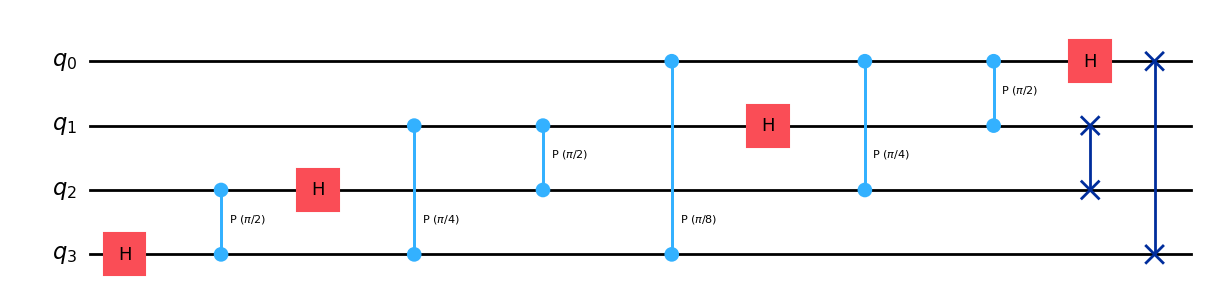

In [4]:
# 4 Qubit QFT
display(QFT(4).decompose().draw("mpl"))